# Make with database: Traffic Signs Preprocessed
- Link: https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed

# Connect gg drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

path_dataset = "/content/drive/MyDrive/Class/nam-4/ky-1/ML/TH2/Dataset"

Mounted at /content/drive


# Importing libraries

In [8]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Blur
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# Loading data

In [7]:
data = pd.read_pickle(path_dataset + '/data0.pickle')
print('keys:', data.keys())
print('train shape:', data['x_train'].shape)
print('test shape:', data['x_test'].shape)
print('validation shape:', data['x_validation'].shape)

keys: dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])
train shape: (86989, 3, 32, 32)
test shape: (12630, 3, 32, 32)
validation shape: (4410, 3, 32, 32)


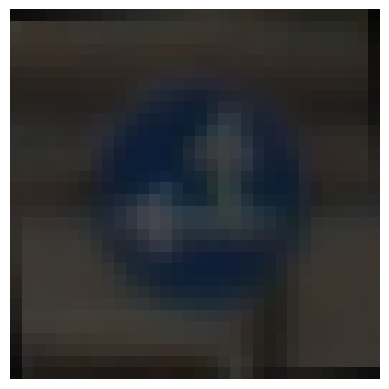

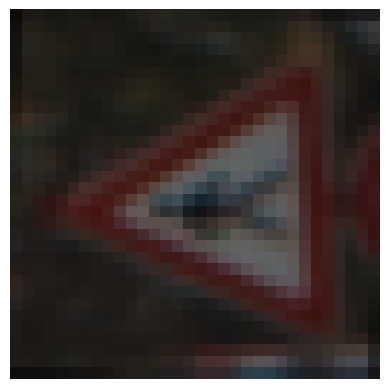

In [9]:
for i in range(2):
    img = data['x_train'][i].T
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torchvision.transforms.functional.to_tensor(self.x[idx].astype(np.uint8).reshape((32, 32, 3)))

        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)
        return {'x': x, 'y': label}

BATCH_SIZE = 256
train_dataset = MyDataset(data['x_train'], data['y_train'], 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(data['x_test'], data['y_test'], 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataset = MyDataset(data['x_validation'], data['y_validation'], 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

# Modeling

In [13]:
class Model(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )

        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [14]:
%%time

n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))

torch.save(model.state_dict(), './model_RGB')

started!
epoch 1/3 finished with train loss: 1.6787635319373186 and test loss: 0.6220262265205383
epoch 2/3 finished with train loss: 0.26207094998920666 and test loss: 0.5232040262222291
epoch 3/3 finished with train loss: 0.15628466379335698 and test loss: 0.4823837685585022
CPU times: user 16min 34s, sys: 4min 40s, total: 21min 14s
Wall time: 21min 40s


In [15]:
def make_report(y_pred , y_true, fig_size = (20,20)):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(figsize=fig_size, conf_mat=cm)
    plt.show()

Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        60
           1       0.96      0.92      0.94       720
           2       0.84      0.94      0.88       750
           3       0.75      0.95      0.84       450
           4       0.93      0.92      0.92       660
           5       0.89      0.74      0.81       630
           6       0.96      0.79      0.87       150
           7       0.94      0.86      0.90       450
           8       0.97      0.86      0.91       450
           9       0.93      0.94      0.93       480
          10       0.96      0.97      0.96       660
          11       0.87      0.93      0.90       420
          12       0.95      0.84      0.89       690
          13       0.89      0.97      0.93       720
          14       0.98      0.98      0.98       270
          15       0.90      0.95      0.93       210
          16       0.95      1.00      0.97       1

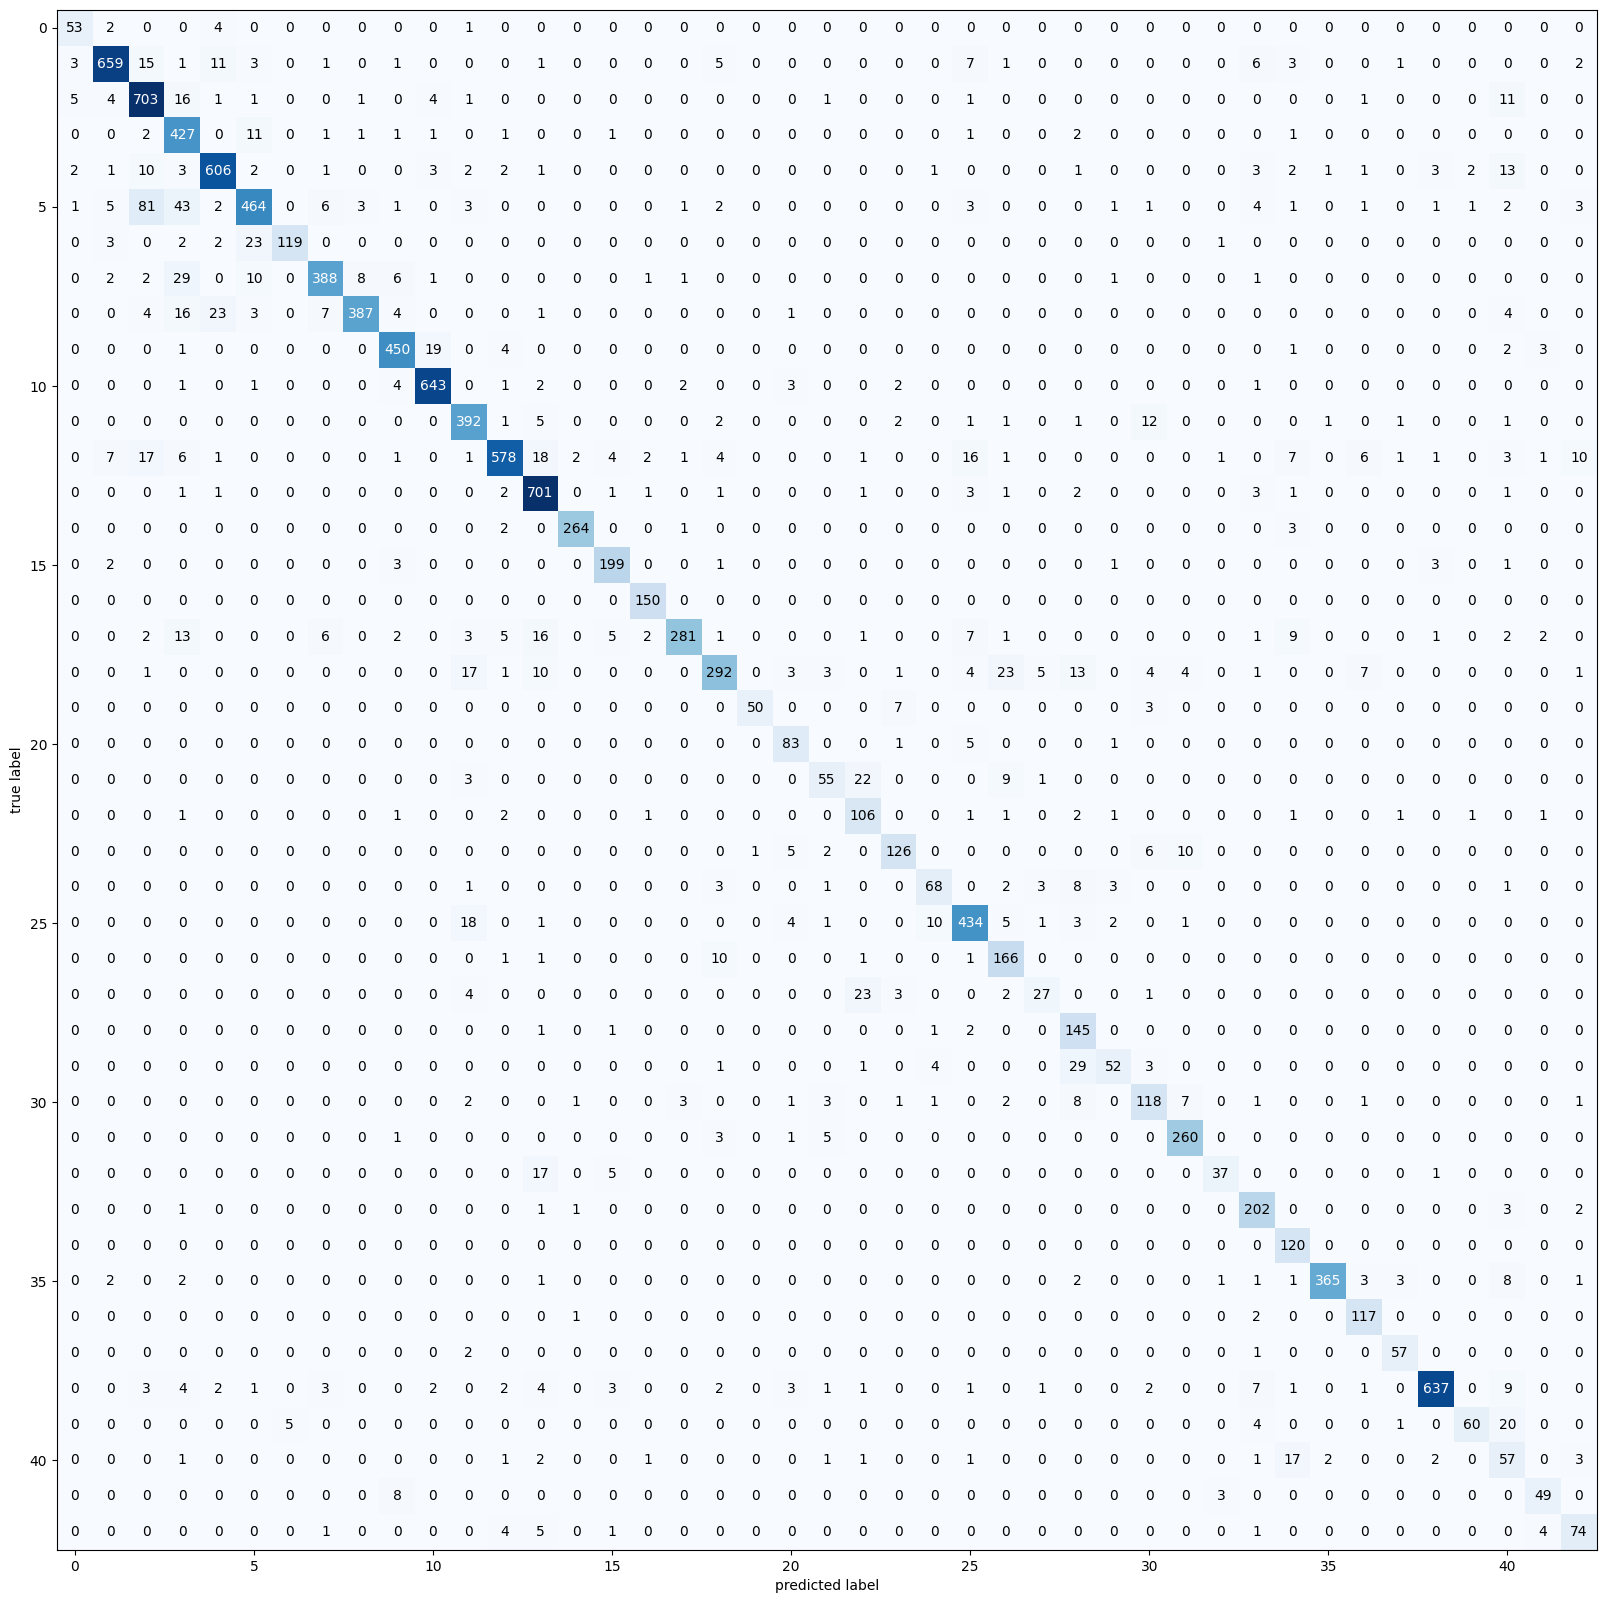

validation

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.97      0.91      0.94       240
           2       0.84      0.91      0.88       240
           3       0.84      1.00      0.91       150
           4       0.95      0.99      0.97       210
           5       0.94      0.80      0.87       210
           6       0.97      1.00      0.98        60
           7       0.93      0.99      0.95       150
           8       1.00      0.85      0.92       150
           9       1.00      0.94      0.97       150
          10       0.98      1.00      0.99       210
          11       0.82      0.96      0.88       150
          12       0.91      0.99      0.95       210
          13       0.92      0.97      0.95       240
          14       0.87      0.97      0.92        90
          15       0.93      1.00      0.96        90
          16       0.73      0.50      0.59  

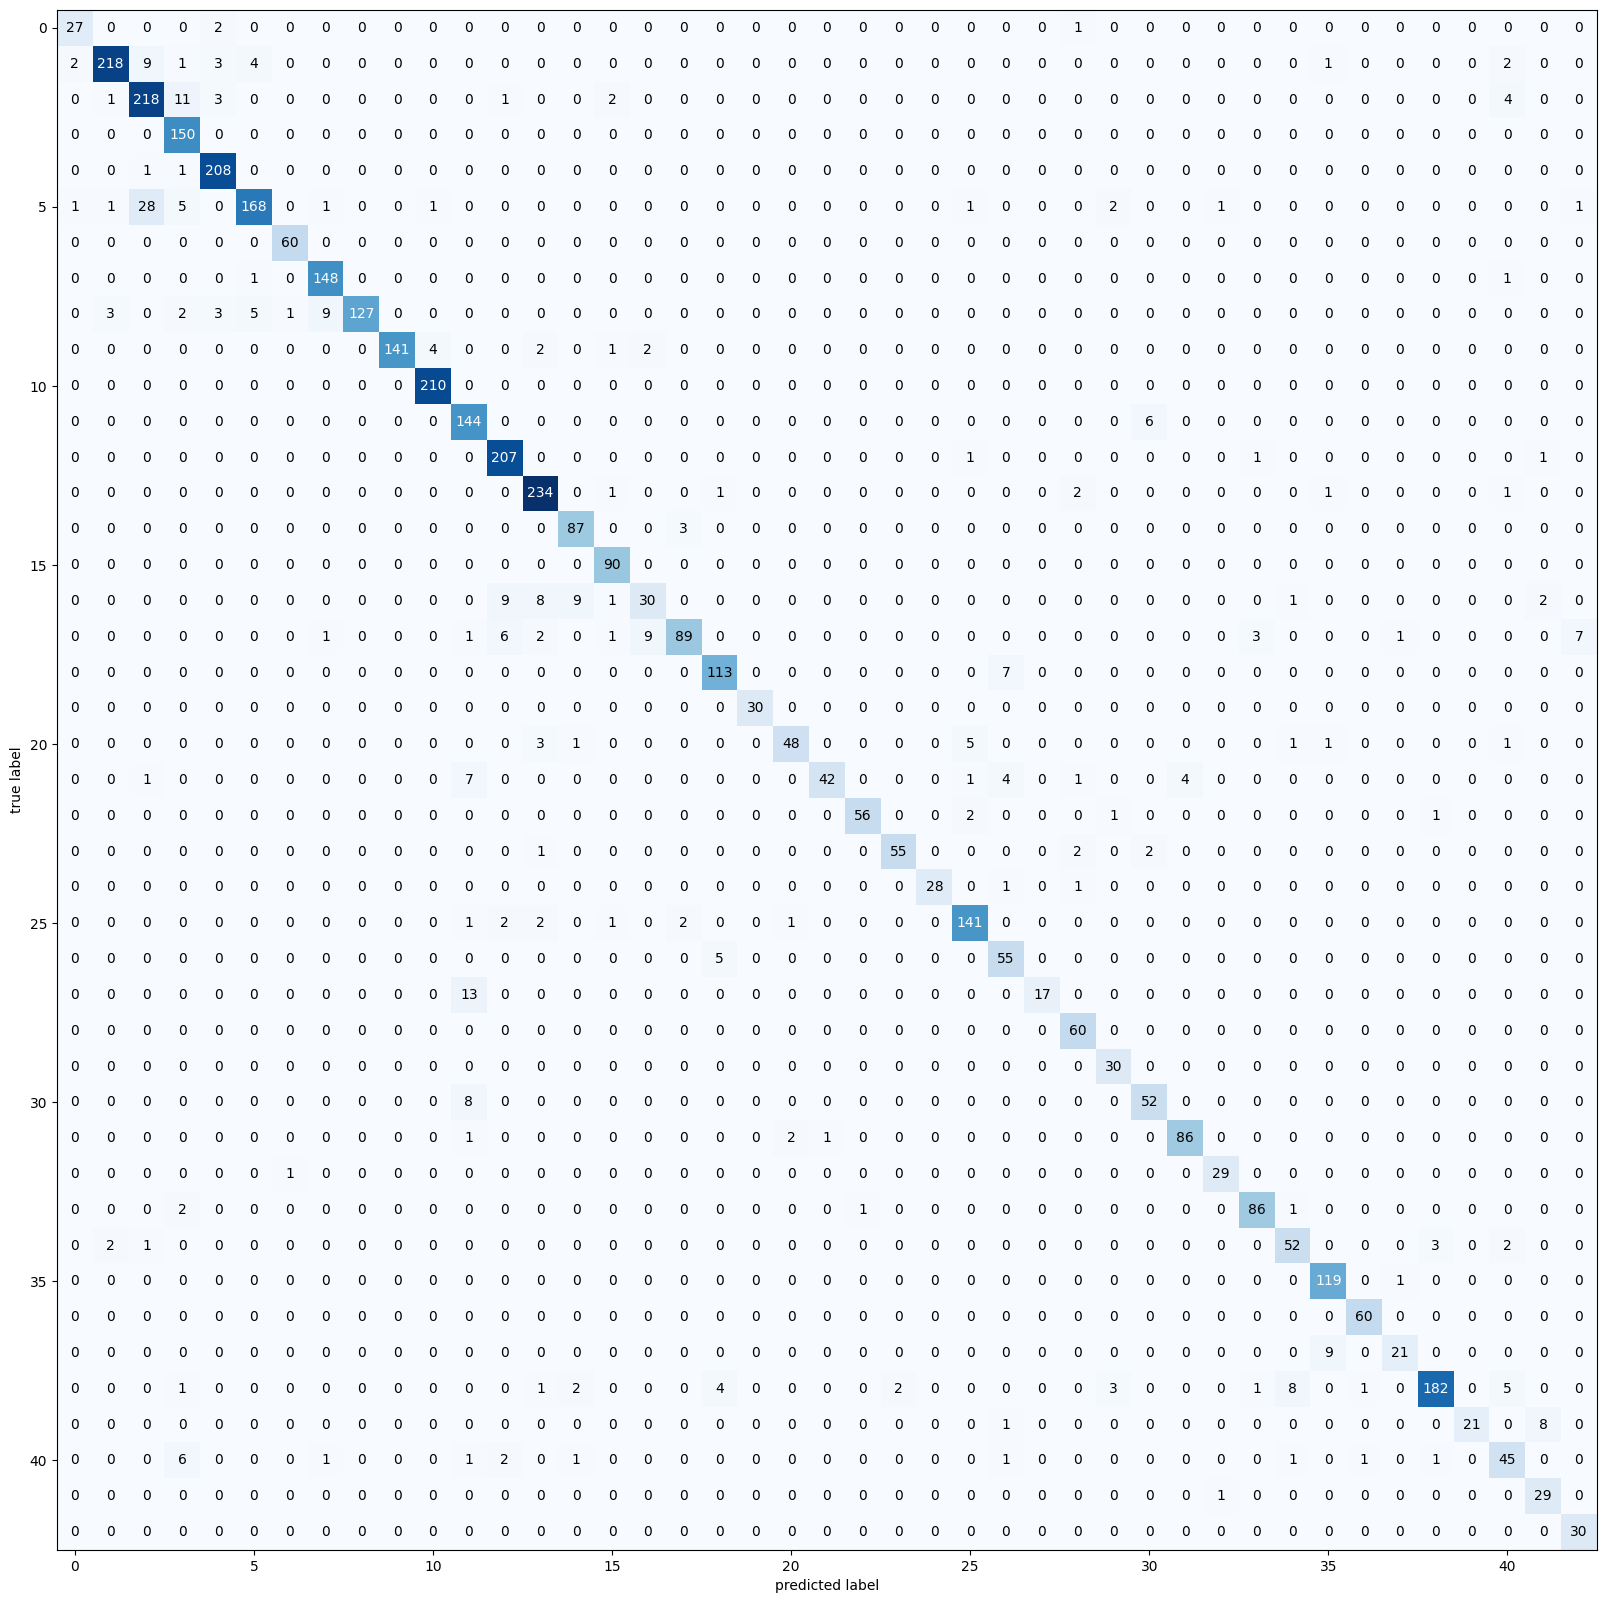

In [16]:
def res(dataLoader):
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)